In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
#making the value object Wrapper
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad =0.0
        self._backward =lambda:None
        self._prev =set(_children)
        self._op = _op
        self.label =label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other =other if isinstance(other,Value) else Value(other)
        out=Value(self.data + other.data ,(self,other) ,"+")

        def _backward():
            self.grad += 1.0*out.grad
            other.grad +=1.0*out.grad
        out._backward =_backward

        return out
    
    def __mul__(self,other):
        other =other if isinstance(other,Value) else Value(other)
        out =Value(self.data*other.data,(self,other) ,"*")

        
        def _backward():
            self.grad += other.data * out.grad
            other.grad +=self.data * out.grad
        out._backward =_backward

        return out
    def __truediv__(self,other):
        return self * other**(-1)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only support int/float powersfor now"
        out = Value(self.data**other ,(self,) , f"**{other}")

        def _backword():
            self.grad += other * (self.data**(other -1))*out.grad
        out._backward = _backword

        return out
    
    def __rmul__(self,other): # other*self
        return self*other
    
    def tanh(self):
        x=self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)   
        out=Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward =_backward
        
        return out 
    
    def exp(self):
        x=self.data
        out = Value(math.exp(x),(self,), 'exp')


        def _backward():
            self.grad += out.data*out.grad
        out._backward =_backward
        
        return out 
    
    def __neg__(self): # -self
        return self* -1
    
    def __sub__(self,other):
        return self + (-other)

    
    def backword(self):

        topo=[]
        visited =set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()



In [40]:
# !pip install graphviz
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in agraph
    nodes,edges =set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format='svg' ,graph_attr={'rankdir':"LR"}) #left to right

    nodes,edges =trace(root)
    for n in nodes:
        uid =str(id(n))
        #for any value in the graph ,create a rectangular('record) node for it
        dot.node(name=uid ,label ="{%s | data % 0.4f |grad % 0.4f}" %(n.label , n.data, n.grad),shape='record')
        if n._op:
            #if this value is a result of some operation,create an op node for it
            dot.node(name = uid + n._op ,label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)) ,str(id(n2)) +n2._op)

    return dot



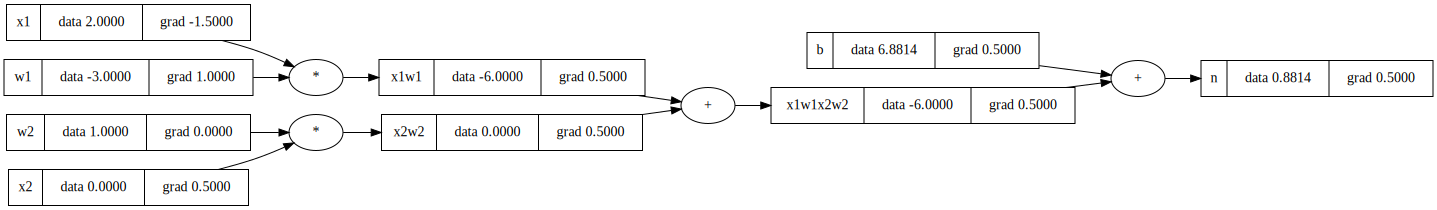

In [41]:
#Neural network inputs x1,x2
x1 =Value(2.0 ,label='x1')
x2 =Value( 0.0,label='x2')
#weights w1 w2
w1 =Value( -3.0,label='w1')
w2 =Value( 1.0,label='w2')
#bias of the neuron b
b= Value(6.8813735870195432 ,label='b')
x1w1 =x1*w1 ; x1w1.label ='x1w1'
x2w2 =x2*w2 ;x2w2.label ='x2w2'
x1w1x2w2 =x2w2 + x1w1 ; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b ; n.label='n'
o =n.tanh() ; o.label='o'
o.backword()
draw_dot(n)

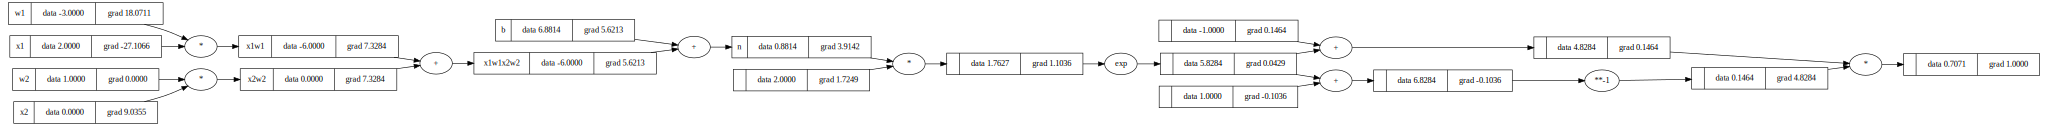

In [42]:
#Neural network inputs x1,x2
x1 =Value(2.0 ,label='x1')
x2 =Value( 0.0,label='x2')
#weights w1 w2
w1 =Value( -3.0,label='w1')
w2 =Value( 1.0,label='w2')
#bias of the neuron b
b= Value(6.8813735870195432 ,label='b')
x1w1 =x1*w1 ; x1w1.label ='x1w1'
x2w2 =x2*w2 ;x2w2.label ='x2w2'
x1w1x2w2 =x2w2 + x1w1 ; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b ; n.label='n'
e =(2*n).exp()
o =(e-1)/(e+1)
o.backword()
draw_dot(o)

In [43]:
# import torch
# x1 = torch.tensor([2.0]).double()           ;x1.requires_grad=True
# x2 = torch.tensor([0.0]).double()           ;x2.requires_grad=True
# w1 = torch.tensor([-3.0]).double()           ;w1.requires_grad=True
# w2 = torch.tensor([1.0]).double()           ;w2.requires_grad=True
# b = torch.tensor([6.8813735870195432]).double()           ;b.requires_grad=True
# n=x1*w1 +x2*w2 +b
# o=torch.tanh(n)
# print(o.data.item())
# o.backward()

# print('---')
# print('x2',x2.grad.item())
# print('w2',w2.grad.item())
# print('x1',x1.grad.item())
# print('w1',w1.grad.item())

In [44]:
import random as random
class Neuron:
  def __init__(self,nin):
    self.w =[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b =Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w +[self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [45]:
x=[2.0,3.0,-1.0]
# n=Neuron(2)
# y=Layer(2,3)
# print(y(x))
# n(x)
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.8942915239747202)

In [46]:
n.parameters()

[Value(data=-0.36593530690094056),
 Value(data=-0.03583672337161503),
 Value(data=-0.26015807711835004),
 Value(data=-0.06049955913993865),
 Value(data=-0.9224620348610046),
 Value(data=0.973907932611296),
 Value(data=-0.7260167914828299),
 Value(data=0.9920540703387126),
 Value(data=0.8234420776492606),
 Value(data=0.04315441640924855),
 Value(data=-0.9959961246193094),
 Value(data=-0.475441055333204),
 Value(data=-0.5669148010244935),
 Value(data=-0.29109178544227166),
 Value(data=-0.8025576329598259),
 Value(data=0.5920183430164181),
 Value(data=0.31411351049104264),
 Value(data=0.7992202217914226),
 Value(data=0.03261381278914466),
 Value(data=-0.8067720229438913),
 Value(data=-0.5570663472867012),
 Value(data=-0.33106269410822975),
 Value(data=0.5458314577321628),
 Value(data=0.5512571005576863),
 Value(data=-0.13955135797298546),
 Value(data=-0.11949852392321336),
 Value(data=0.782578020493016),
 Value(data=0.3681943364497615),
 Value(data=0.1456243892908462),
 Value(data=0.08952

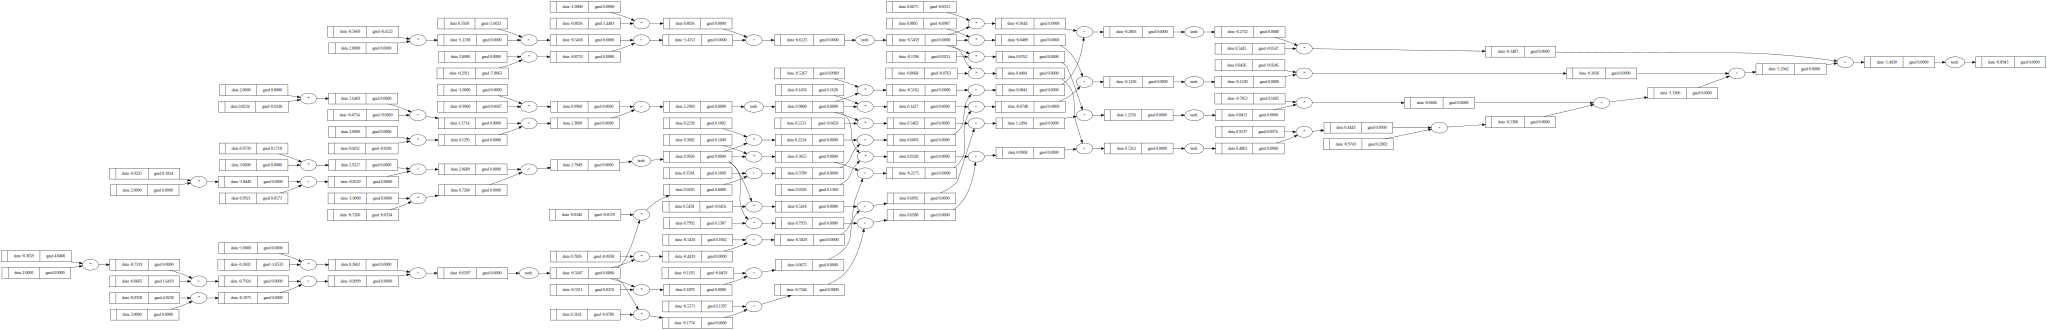

In [47]:
n(x).backword()
draw_dot(n(x))

In [50]:
xs=[[2.0,3.0,-1.0],
    [3,0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]]
ys=[1.0,-1.0,-1.0,1.0] #desired output
# n.layers[0].neurons[0].w[0].grad


In [52]:
for k in range(10):
    #forward pass
    ypred=[n(x) for x in xs]

    loss = [(yout-ygt)**2 for ygt,yout in zip(ys,ypred)]
    total_loss = Value(0.0)
    for l in loss:
        total_loss = total_loss + l
    loss =total_loss
    print(loss)

    #backward pass
    for p in n.parameters():

        p.grad=0.0
        loss.backword()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k,loss.data)
  
    


OverflowError: math range error

In [ ]:
ypred

[Value(data=0.4050781719823356),
 Value(data=0.4050807969085201),
 Value(data=-0.9955058080054038),
 Value(data=0.4050807895103269)]